# 2. Create the total map for all frequencies by adding CMB realization, Synchrotron realization, and Noise realization together

In [1]:
# !pip install skyclean --upgrade
import os
import healpy as hp
import skyclean as sc
# from skyclean import hp_alm_2_mw_alm, arcmin_to_radians, reduce_hp_map_resolution

In [30]:
# This function is not included in the Skyclean package because the storage directory and beam deconvolution process
#  are dependent on the user.
def create_and_save_total_map(frequency, realization, desired_lmax, directory="CMB_realizations"):
    """
    Processes the CMB, Synchrotron, and Noise maps for each frequency and realization, then combines them.

    Beam deconvolution is applied to the CMB map.
    The CMB, Synchrotron, and Noise maps are then reduced to the desired lmax.
    The reduced maps are then combined to create the total map.

    Parameters:
        frequency (str): frequency identifiers.
        realization (int): realization identifiers.
        desired_lmax (int): Maximum multipole moment for spherical harmonics.
        directory (str): Directory containing the input map files.
    """
    # Ensure the directory exists
    if not os.path.exists("data/CMB_total"):
        os.makedirs("data/CMB_total")

    print(f"Processing maps for frequency {frequency} and realization {realization}")
        
    # Define file paths
    CMB_file_path = f"{directory}/febecop_ffp10_lensed_scl_cmb_{frequency}_mc_{realization:04d}.fits"
    synchrotron_file_path = f"{directory}/COM_SimMap_synchrotron-ffp10-skyinbands-{frequency}_2048_R3.00_full.fits"
    noise_file_path = f"{directory}/ffp10_noise_{frequency}_full_map_mc_{realization:05d}.fits"
    
    # Read maps
    original_hp_CMB_map, cmb_header = hp.read_map(CMB_file_path, h = True)
    synchrotron, synchrotron_header = hp.read_map(synchrotron_file_path, h = True)
    noise, noise_header = hp.read_map(noise_file_path, h = True)

    # Remember to check the units of the maps by print(header) (CMB_K, MJy/sr, etc.)
    # The unit coversion: https://wiki.cosmos.esa.int/planckpla2015/index.php/UC_CC_Tables 
    print(cmb_header)
    #print(synchrotron_header)
    #print(noise_header)
    
    if frequency == "545":
        unit_conversion = 58.0356
        original_hp_CMB_map = original_hp_CMB_map / unit_conversion
        synchrotron = synchrotron / unit_conversion
        noise =  noise / unit_conversion
    if frequency == "857":
        unit_conversion = 2.2681
        original_hp_CMB_map = original_hp_CMB_map / unit_conversion
        synchrotron = synchrotron / unit_conversion
        noise =  noise / unit_conversion
    print(f"original @ {frequency}:{original_hp_CMB_map}")
    # Define your own beam function path
    HFI_beam_path = "HFI_beams/"+ f"Bl_T_R3.01_fullsky_{frequency}x{frequency}.fits"
    
    beam_decon_cmb = sc.beam_deconvolution(original_hp_CMB_map, frequency, desired_lmax, sc.arcmin_to_radians(5), HFI_beam_path)
    print(f"deconved @ {frequency}:{beam_decon_cmb}")
    
    # # Calculate nside based on lmax
    nside = desired_lmax // 2
            
        
    new_cmb,_ = sc.reduce_hp_map_resolution(beam_decon_cmb, desired_lmax, nside)
    new_synchrotron,_  = sc.reduce_hp_map_resolution(synchrotron, desired_lmax, nside)
    new_noise,_  = sc.reduce_hp_map_resolution(noise, desired_lmax, nside)
    #total map
    csn = new_cmb + new_synchrotron + new_noise 
    # Save processed maps
    map_dict = {
        "CMB": new_cmb,
        "Synchrotron": new_synchrotron,
        "Noise": new_noise,
        "CSN": csn
    }
    for map_type, _map in map_dict.items():
        filename = f"data/CMB_total/{map_type}_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"
        hp.write_map(filename, _map, dtype="float64", overwrite=True)


In [31]:
# Usage of the create_and_save_total_map function

# Define frequencies and realizations
#frequencies = ["030", "044", "070", "100", "143", "217", "353", "545", "857"]
frequencies = ["545", "857"]
realizations = list(range(1)) 

desired_lmax = 256
for frequency in frequencies:
    for realization in realizations:
        path = f"CMB_total/CSN_HP_Map_F{frequency}_L{desired_lmax}_R{realization:04d}.fits"
        if os.path.exists(path):
            print(f"File {path} already exists. Skipping download.")
            continue
        create_and_save_total_map(frequency, realization, desired_lmax, directory="data/CMB_realizations")



Processing maps for frequency 545 and realization 0
[('XTENSION', 'BINTABLE'), ('BITPIX', 8), ('NAXIS', 2), ('NAXIS1', 4096), ('NAXIS2', 49152), ('PCOUNT', 0), ('GCOUNT', 1), ('TFIELDS', 1), ('TTYPE1', 'INTENSITY'), ('TFORM1', '1024E'), ('TUNIT1', 'MJy/sr'), ('PIXTYPE', 'HEALPIX'), ('ORDERING', 'RING'), ('EXTNAME', 'xtension'), ('NSIDE', 2048), ('FIRSTPIX', 0), ('LASTPIX', 50331647), ('INDXSCHM', 'IMPLICIT'), ('OBJECT', 'FULLSKY')]
original @ 545:[-1.6683042e-04 -1.9372891e-04 -1.6956058e-04 ...  8.3714294e-06
  2.0888519e-05  4.5282326e-05]
deconved @ 545:[-1.72343487e-04 -1.74552832e-04 -1.75327912e-04 ...  9.55822148e-06
  6.77343881e-06 -1.07156551e-07]
Processing maps for frequency 857 and realization 0
[('XTENSION', 'BINTABLE'), ('BITPIX', 8), ('NAXIS', 2), ('NAXIS1', 4096), ('NAXIS2', 49152), ('PCOUNT', 0), ('GCOUNT', 1), ('TFIELDS', 1), ('TTYPE1', 'INTENSITY'), ('TFORM1', '1024E'), ('TUNIT1', 'MJy/sr'), ('PIXTYPE', 'HEALPIX'), ('ORDERING', 'RING'), ('EXTNAME', 'xtension'), ('NS

(array([2.8616e+04, 2.6902e+04, 1.7872e+04, 6.2420e+03, 2.7670e+03,
        1.6760e+03, 1.0310e+03, 7.9400e+02, 6.2700e+02, 4.9800e+02,
        4.4000e+02, 3.1900e+02, 2.8000e+02, 2.2100e+02, 2.0800e+02,
        1.8000e+02, 1.6900e+02, 1.3900e+02, 1.2000e+02, 1.1100e+02,
        9.0000e+01, 7.9000e+01, 8.5000e+01, 8.1000e+01, 7.1000e+01,
        6.3000e+01, 6.0000e+01, 5.7000e+01, 5.3000e+01, 6.2000e+01,
        4.3000e+01, 3.4000e+01, 4.0000e+01, 3.3000e+01, 3.9000e+01,
        2.7000e+01, 3.1000e+01, 3.1000e+01, 3.0000e+01, 2.5000e+01,
        2.8000e+01, 1.8000e+01, 1.5000e+01, 3.0000e+01, 2.3000e+01,
        1.5000e+01, 1.4000e+01, 2.8000e+01, 2.3000e+01, 2.2000e+01,
        2.1000e+01, 1.6000e+01, 2.1000e+01, 1.8000e+01, 2.1000e+01,
        1.2000e+01, 1.4000e+01, 1.7000e+01, 8.0000e+00, 1.5000e+01,
        1.2000e+01, 1.1000e+01, 7.0000e+00, 1.4000e+01, 7.0000e+00,
        1.1000e+01, 5.0000e+00, 1.3000e+01, 7.0000e+00, 6.0000e+00,
        1.0000e+01, 1.2000e+01, 6.0000e+00, 9.00

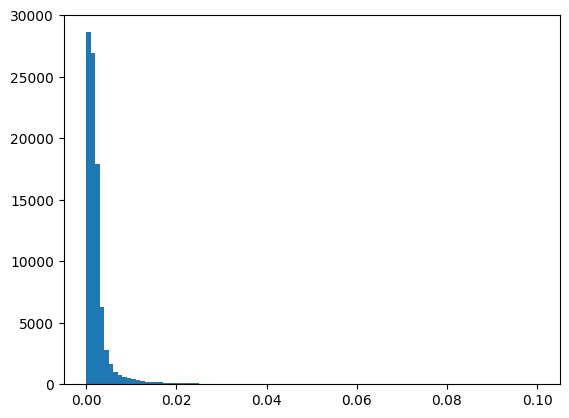

In [48]:
import numpy as np
import matplotlib.pyplot as plt
filename = f"data/CMB_total/CMB_HP_Map_F{{frequency}}_L256_R{0:04d}.fits"
frequencies = ["217", "353"]
map1=hp.read_map(filename.format(frequency=frequencies[0]))
map2=hp.read_map(filename.format(frequency=frequencies[1]))
plt.hist((map2-map1)/map1, bins=100, range = [0,0.1])


# Reference: Skyclean functions to create total map

In [ ]:
# Skyclean functions to create total map

import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
# import os
from astropy.io import fits #For beam deconvolution

def reduce_hp_map_resolution(hp_map, lmax, nside):
    """
    Processes a Healpix map by converting it to spherical harmonics and back,
    and reducing the resolution.
    
    Parameters:
        map_data (numpy.ndarray): Input map data.
        lmax (int): Maximum multipole moment for spherical harmonics.
        nside (int): Desired nside resolution for the output map.
        
    Returns:
        numpy.ndarray: Processed map data.
    """
    hp_alm = hp.map2alm(hp_map, lmax=lmax)
    processed_map = hp.alm2map(hp_alm, nside=nside)
    return processed_map, hp_alm


def beam_deconvolution(hp_map, frequency, lmax, standard_fwhm_rad, beam_path, LFI_beam_fwhm = {"030": 32.33, "044": 27.01, "070": 13.25}):
    """
    Performs beam deconvolution on the given CMB map data and returns the deconvolved map.

    Parameters:
        cmb_map (fits): CMB map data.
        frequency (str): Frequency identifier (e.g., "030", "044").
        lmax (int): Maximum multipole moment.
        standard_fwhm_rad (float): Standard beam full-width half-maximum in radians.
        beam_path (str): Path to the beam data file specific to the frequency.
        LFI_beam_fwhm (dict): Dictionary of beam full-width half-maximum (FWHM) in arcminutes for LFI frequencies.
    Returns:
      deconvolved_map (fits): The deconvolved CMB map.
    """

    nside = hp.get_nside(hp_map)
    cmb_alm = hp.map2alm(hp_map, lmax=lmax)

    
    # Standard beam for the desired FWHM
    Standard_bl = hp.sphtfunc.gauss_beam(standard_fwhm_rad, lmax=lmax-1, pol=False)
    
    # Pixel window function
    pixwin = hp.sphtfunc.pixwin(nside, lmax=lmax, pol=False)
    
    # LFI beam deconvolution
    if frequency in {"030", "044", "070"}:
        # Deconvolution for lower frequencies
        fwhm_rad = np.radians(LFI_beam_fwhm[frequency] / 60)
        bl = hp.sphtfunc.gauss_beam(fwhm_rad, lmax=lmax-1, pol=False)
        new_cmb_alm = hp.almxfl(cmb_alm, 1/bl)
    # HFI beam deconvolution
    else:
        # Deconvolution using FITS file for higher frequencies
        hfi = fits.open(beam_path)
        beam = hfi[1].data["TEMPERATURE"]
        new_cmb_alm = hp.almxfl(cmb_alm, 1/beam)
    
    # Apply pixel window function and standard beam
    new_cmb_alm = hp.almxfl(new_cmb_alm, 1/pixwin)
    new_cmb_alm = hp.almxfl(new_cmb_alm, Standard_bl)
    
    # Convert back to map
    deconvolved_map = hp.alm2map(new_cmb_alm, nside=nside)
    
    return deconvolved_map

